The following notebook is pretty old/outdated now, and probably does not work out of the box anymore.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader, Dataset
from omegaconf import OmegaConf
from pathlib import Path
from bachelors_thesis.modeling.sigloc import SigLoc12
from bachelors_thesis.modeling.siglabv2 import SigLabV2
from bachelors_thesis.modeling.datasets.sigloc_dataset import SigLocDataset
from bachelors_thesis.modeling.train import eval_loop
from bachelors_thesis.evaluation import set_level_accuracy, lead_level_accuracy
from bachelors_thesis.utils import plot_ecg, confusion_matrix, PRECORDIAL_LEAD_NAMES, apply_preprocessors
from bachelors_thesis.data.ptbxl_utility import get_ecg_signals_from_file
import wandb
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-25 10:49:43.421 | INFO     | bachelors_thesis.config:<module>:11 - PROJ_ROOT path is: C:\Users\natem\bachelors_thesis


ModuleNotFoundError: No module named 'bachelors_thesis.modeling.sigloc'

In [28]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact("nateml-maastricht-university/bachelors-thesis/00_siglabv2_test:latest")
artifact_path = artifact.download()

run = api.run("nateml-maastricht-university/bachelors-thesis/4zf4bqsa")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)

wandb:   1 of 1 files downloaded.  


In [29]:
cfg.model.feature_dim

128

In [30]:
# Load the model
checkpoint = torch.load(artifact_path + "/00_siglabv2_test.pth", map_location=torch.device('cpu'))

# Cast the model to the correct type
model = SigLabV2(cfg.model)
model.to("cpu")
model.load_state_dict(checkpoint)
model.eval()

SigLabV2(
  (encoder): CNNGRUEncoder(
    (cnn_encoder): Sequential(
      (0): InceptionBlock(
        (branch1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 60, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(60, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 60, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(60, 32, kernel_size=(11,), stride=(1,), paddin

In [40]:
# Load the validation data
val_data = np.load('../../data/processed/ptbxl100all/precordial/val.npy')

# Preprocess the data
val_data = apply_preprocessors(val_data, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)

# Convert to tensor
val_data = torch.from_numpy(val_data).float()

# Reshape to (_, 6, 1000)
# val_data = val_data.view(-1, 6, 1000)
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

torch.Size([2183, 6, 1000])


In [41]:
# Create a dataloader for the validation data
dataset = SigLocDataset(val_data)
batch_size = 48
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [42]:
model.eval()
logits = np.zeros((len(dataset), 6, 6))
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to('cpu')

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        these_logits = model(batch)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

logits.shape

torch.Size([48, 6, 1000])


(2183, 6, 6)

In [43]:
targets = torch.arange(6, device=logits[0].device).expand(2183, -1)
targets.shape

torch.Size([2183, 6])

In [44]:
# Convert logits to tensor
logits = torch.from_numpy(logits).float()

In [45]:
# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs[0])


[[99.91  0.08  0.01  0.    0.    0.  ]
 [ 0.07 99.91  0.02  0.    0.    0.  ]
 [ 0.01  0.04 99.93  0.01  0.    0.  ]
 [ 0.    0.    0.01 99.82  0.14  0.03]
 [ 0.    0.    0.    0.12 99.77  0.11]
 [ 0.    0.    0.    0.03  0.1  99.87]]


In [46]:
set_acc = set_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
lead_acc = lead_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

Set level accuracy: 0.9363
Lead level accuracy: 0.9765


In [51]:
hungarian_preds = hungarian_predictions(logits.cpu().numpy())
hungarian_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
hungarian_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
print(f"Hungarian set level accuracy: {hungarian_set_acc:.4f}")
print(f"Hungarian lead level accuracy: {hungarian_lead_acc:.4f}")

Hungarian set level accuracy: 0.9437
Hungarian lead level accuracy: 0.9765


In [52]:
# Find outliers
preds = np.argmax(logits.cpu().numpy(), axis=2)

# These are samples where the model predicted all 6 classes wrong 
outliers = np.where(np.all(preds != targets.cpu().numpy(), axis=1))[0]
print(preds[outliers][1])
print(len(outliers))

print("Probabilities:")
print(probs[outliers][1])

# These are samples where the model predicted all 6 classes right
correct = np.where(np.all(preds == targets.cpu().numpy(), axis=1))[0]

[5 3 0 0 5 4]
3
Probabilities:
[[ 5.28 19.38 20.04 11.86 14.55 28.88]
 [ 5.02 17.24  4.68 67.57  4.86  0.63]
 [50.25  1.85  9.06 36.4   1.42  1.03]
 [66.62  7.3  17.11  7.38  1.03  0.56]
 [ 0.18  0.13  0.12  0.08 24.28 75.21]
 [ 0.31  0.17  0.21  0.09 92.14  7.08]]


In [53]:
# I want to find all cases where the model predicted a lead more than 2 "positions" away from the correct lead
# E.g. if the model predicted 0, but the correct lead was 3, this is a distance of 3
wrongness_thresh = 3
wrong = np.where(np.abs(preds - targets.cpu().numpy()) > wrongness_thresh)[0]
print(len(wrong))

15


In [59]:
# Let's take a look at the metadata for these samples
meta = np.load('../../data/processed/ptbxl100all/meta_val.npy', allow_pickle=True)
meta = pd.DataFrame(metadata)

0                                                4961.0
1                                                  79.0
2                                                     0
3                                                 166.0
4                                                  54.0
5                                                  10.0
6                                                   1.0
7                                            AT-6 C 5.8
8                                   1989-07-23 09:10:01
9     atrial fibrillation with rapid ventricular res...
10    {'ASMI': 100.0, 'ILMI': 100.0, 'IVCD': 100.0, ...
11                                                  NaN
12                                          Stadium III
13                                                  NaN
14                                                  0.0
15                                                False
16                                                False
17                                              

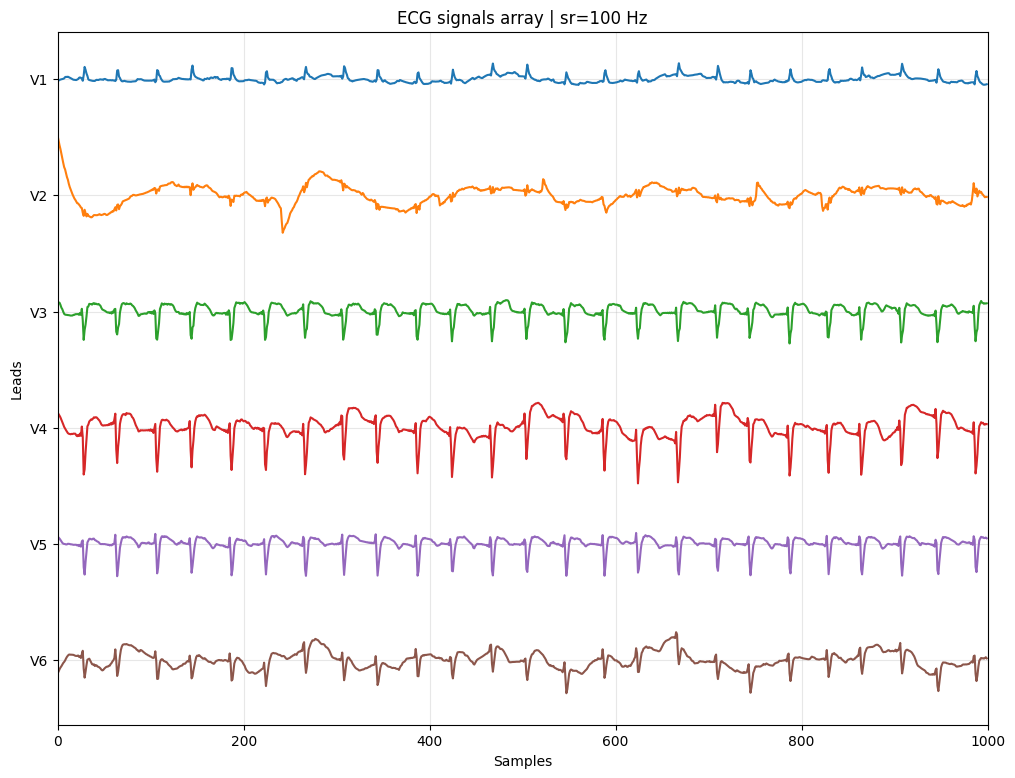

In [60]:
# lets take a look at the signals from the first outlier
import matplotlib.pyplot as plt

signals = val_data[outliers[0]].cpu().numpy()

#plot_signals(signals, time_cutoff=1000)
plot_ecg(signals, sampling_rate=100)
print(meta.iloc[outliers[0]])

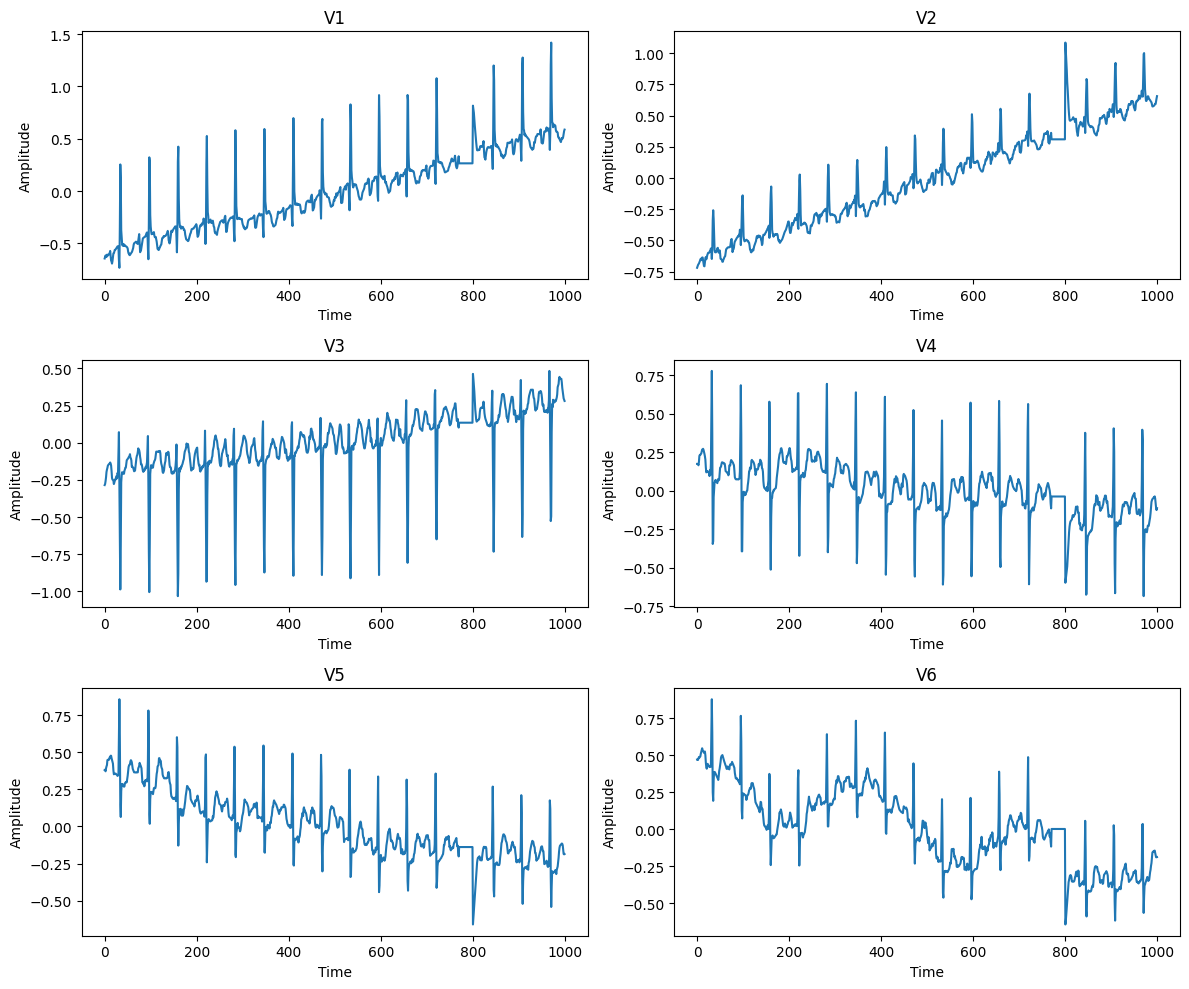

In [27]:
# Lets try remove the artifact at the end of the signal by zeroing it out
signals_corrected = signals.copy()
for i in range(signals_corrected.shape[0]):
    signals_corrected[i][770:800] = np.mean(signals_corrected[i][700:770])
plot_signals(signals_corrected, time_cutoff=1000)

In [28]:
# Lets try to predict again with the corrected signals
signals_corrected_torch = torch.from_numpy(signals_corrected.reshape(1, 6, 1000)).float().to('cuda')
print(signals_corrected_torch.shape)
with torch.no_grad():
    _, these_logits = model(signals_corrected_torch)

# Convert logits to probabilities
probs = torch.nn.functional.softmax(these_logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs)

# Display the predicted lead
pred = np.argmax(these_logits.cpu().numpy(), axis=2)
print(pred)

torch.Size([1, 6, 1000])
[[[ 0.02  0.07  0.03  1.39 95.77  2.72]
  [ 0.53  0.41  0.19  0.27  0.52 98.08]
  [99.17  0.8   0.    0.    0.01  0.02]
  [ 0.22 61.44 37.97  0.09  0.14  0.15]
  [ 0.4   9.89 73.69 13.82  1.64  0.56]
  [ 0.98 10.52 20.18 56.35  8.77  3.2 ]]]
[[4 5 0 1 2 3]]


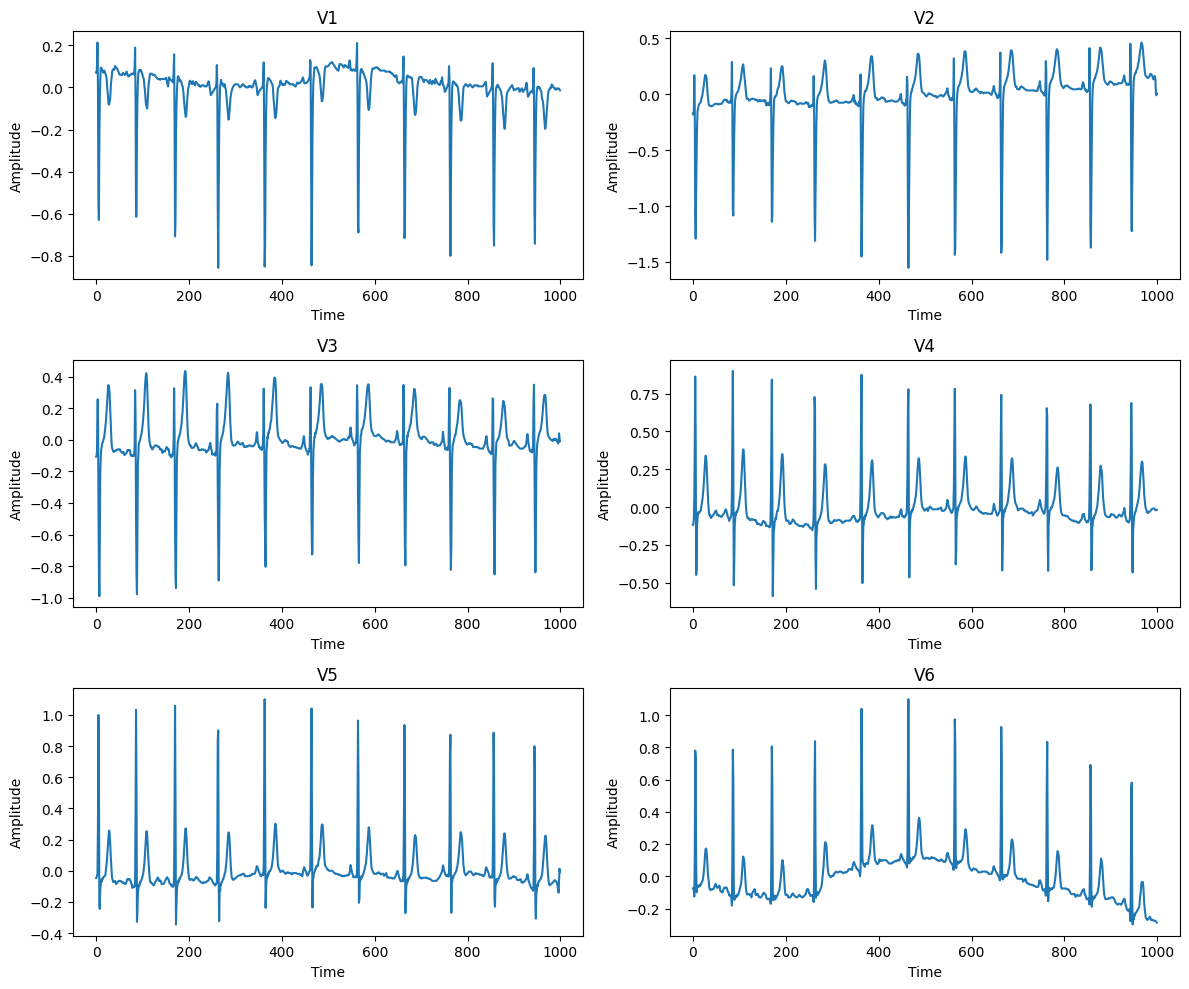

In [29]:
# lets do the same visualization for the first correct sample
signals = val_data[correct[1]].cpu().numpy()

plot_signals(signals, time_cutoff=1000)

The above uses a model that was not trained on preprocessed data. I will now evaluate a model that was trained on data with a highpass filter to remove baseline wander.

In [ ]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact("nateml-maastricht-university/bachelors-thesis/04_sigloc12_weight_decay_augment_True_best:v18")
artifact_path = artifact.download()

run = api.run("nateml-maastricht-university/bachelors-thesis/gmzc3d21")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)

# Load the model
checkpoint = torch.load(artifact_path + "/04_sigloc12_weight_decay_augment_True_best.pth", map_location=torch.device('cuda'))

# Cast the model to the correct type
model = SigLoc12(cfg.model)
model.to("cuda")
model.load_state_dict(checkpoint)
model.eval()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


In [19]:
import ast

# Load the validation data
val_data = np.load('../../data/processed/ptbxl100all/val.npy')
meta = pd.read_csv('../../data/processed/ptbxl100all/meta_val.csv')

# Convert scp code strings to dictionaries
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(codes_above_threshold)

print(val_data.shape)
print(meta.shape)

(2183, 1000, 6)
(2183, 31)


In [4]:
val_data

array([[[ 4.500e-02, -5.000e-03,  5.000e-03, -5.500e-02, -7.000e-02,
         -4.000e-02],
        [ 4.500e-02, -7.000e-03,  1.000e-03, -5.500e-02, -7.000e-02,
         -4.000e-02],
        [ 4.500e-02, -1.300e-02, -6.000e-03, -5.500e-02, -7.300e-02,
         -4.500e-02],
        ...,
        [-4.700e-02, -2.560e-01, -3.350e-01, -1.900e-01, -1.840e-01,
         -4.000e-03],
        [-5.900e-02, -2.550e-01, -3.250e-01, -1.860e-01, -1.880e-01,
          2.000e-03],
        [-6.400e-02, -2.550e-01, -3.150e-01, -1.870e-01, -1.900e-01,
         -2.000e-03]],

       [[ 7.100e-02, -1.730e-01, -1.060e-01, -1.180e-01, -4.700e-02,
         -7.400e-02],
        [ 6.800e-02, -1.810e-01, -1.010e-01, -1.100e-01, -4.300e-02,
         -7.800e-02],
        [ 1.030e-01, -1.420e-01, -6.700e-02, -7.800e-02, -3.300e-02,
         -8.700e-02],
        ...,
        [-6.000e-03,  1.400e-02,  4.200e-02, -1.900e-02, -6.600e-02,
         -2.780e-01],
        [-1.100e-02, -9.000e-03,  1.100e-02, -2.100e-02,  1.30

In [3]:
from bachelors_thesis.registries.preprocessor_registry import get_preprocessor

def apply_preprocessors(data, sampling_rate, preprocessors: list):
    data_filtered = data.copy()
    for prep_param in preprocessors:
        prep = get_preprocessor(prep_param._preprocessor_)
        data_filtered = prep(data_filtered, sampling_rate=sampling_rate, **prep_param)
    return data_filtered

In [6]:
# Apply filter(s) to the signals
val_data_filtered = apply_preprocessors(val_data, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)

In [7]:
# Convert to tensor
val_data_filtered = torch.from_numpy(val_data_filtered).float()

# Reshape to (_, 6, 1000)
val_data_filtered = val_data_filtered.permute(0, 2, 1)
print(val_data_filtered.shape)

torch.Size([2183, 6, 1000])


In [8]:
# Create a dataloader for the validation data
dataset = SigLocDataset(val_data_filtered)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [9]:
model.eval()
logits = np.zeros((len(dataset), 6, 6))
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to('cuda')

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        _, these_logits = model(batch)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

logits.shape

NameError: name 'model' is not defined

In [10]:
targets = torch.arange(6, device=logits[0].device).expand(2183, -1)

# Convert logits to tensor
logits = torch.from_numpy(logits).float()

# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs[0])

preds = np.argmax(logits.cpu().numpy(), axis=2)

# Accuracy
lead_acc = lead_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
set_acc = set_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

NameError: name 'logits' is not defined

In [12]:
# Lets try the hungarian algorithm on the logits
hungarian_preds = hungarian_predictions(logits)
print(hungarian_preds.shape)
print(hungarian_preds[2])

(2183, 6)
[0 1 2 3 4 5]


In [13]:
# Now lets calculate the accuracy again using the new
# predictions
hungarian_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
hungarian_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
print(f"Hungarian Set level accuracy: {hungarian_set_acc:.4f}")
print(f"Hungarian Lead level accuracy: {hungarian_lead_acc:.4f}")

Hungarian Set level accuracy: 0.9143
Hungarian Lead level accuracy: 0.9606


In [14]:
hungarian_preds.shape

(2183, 6)

In [15]:
targets.shape

torch.Size([2183, 6])

In [135]:
mistake_mask = hungarian_preds != targets.cpu().numpy()
mistake_counts = mistake_mask.sum(axis=1)
wrongness_thresh = 6
wrong_hungarian = np.where(mistake_counts >= wrongness_thresh)[0]
len(wrong_hungarian)

9

In [ ]:
wrong_hungarian

array([  36,  483,  837,  883, 1215, 1299, 1427, 1753, 1911])

In [137]:
for idx in wrong_hungarian:
    print(hungarian_preds[idx])

[4 3 1 2 5 0]
[1 2 3 4 5 0]
[5 4 3 2 1 0]
[1 3 0 2 5 4]
[5 4 3 1 2 0]
[1 2 3 5 0 4]
[5 0 1 2 3 4]
[1 2 3 4 5 0]
[5 2 1 0 3 4]


In [1]:
# Lets plot these
idx = wrong_hungarian[0]
signals = val_data_filtered[idx].cpu().numpy()
str_predictions = [PRECORDIAL_LEAD_NAMES[p] for p in hungarian_preds[idx]]
plot_ecg(signals, sampling_rate=100, predictions=str_predictions)
print(meta.iloc[idx].report)
print(meta.iloc[idx].scp_codes)

NameError: name 'wrong_hungarian' is not defined

In [185]:
# lets print out the confidence of the model for the predictions
print(probs[idx])

[[47.67  6.83  4.69 10.03 25.66  5.12]
 [ 1.45 11.62 14.03 47.19 24.13  1.58]
 [ 0.87 12.45 14.25 46.13 24.84  1.46]
 [ 0.01 31.63 59.26  8.63  0.45  0.02]
 [32.79  1.06  1.5   0.91  9.39 54.35]
 [76.25  0.42  0.48  0.29  4.38 18.17]]


In [165]:
# Print the metadata for this sample
print(meta.iloc[idx].to_string())

Unnamed: 0                                                                                                                                                                                              10955
ecg_id                                                                                                                                                                                                  10982
patient_id                                                                                                                                                                                             4295.0
age                                                                                                                                                                                                      73.0
sex                                                                                                                                                                             

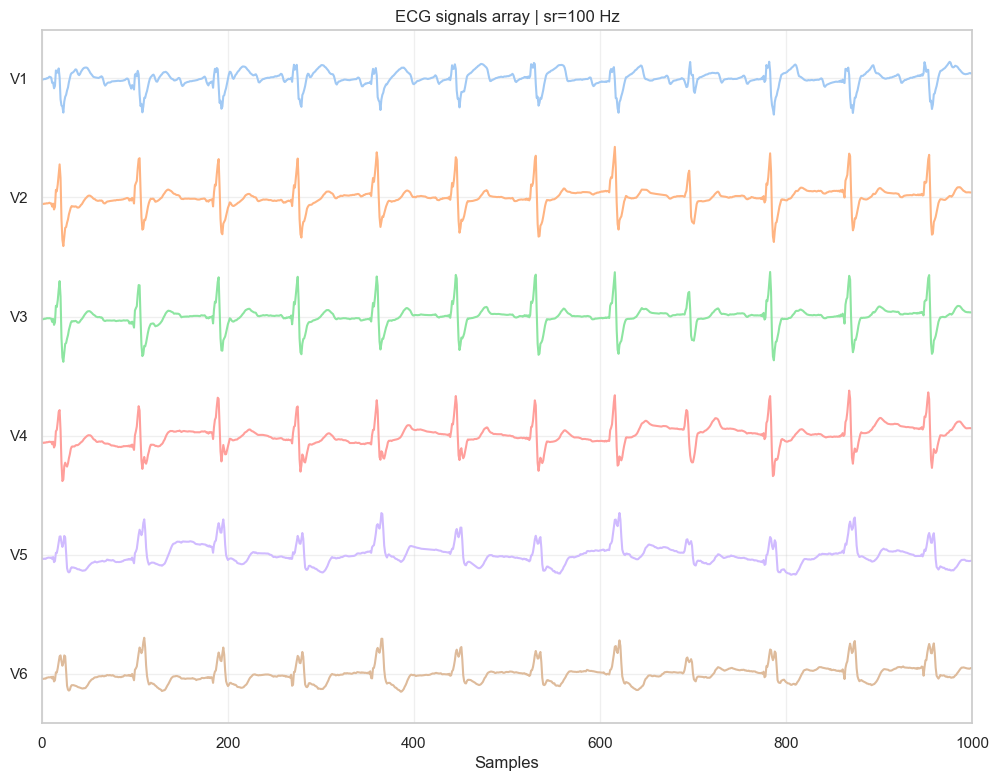

In [279]:
# make sure the metadata corresponds to the signals
ref_sig, leads = get_ecg_signals_from_file(meta.iloc[idx].filename_lr)
# Apply the same preprocessing to the reference signal
# ref_sig = apply_preprocessors(ref_sig, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)
plot_ecg(ref_sig, sampling_rate=100, leads=leads)

In [280]:
meta.iloc[idx].ecg_id

np.int64(190)

In [115]:
# Lets inspect the metadata for these samples
pd.set_option('display.max_columns', None)
meta.iloc[wrong_hungarian]

,Unnamed: 0,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass,present_codes
35,181,189,13112.0,74.0,0,NaN,NaN,NaN,3.0,AT-6 C,1986-03-21 08:54:03,slag med avvikande impulsutbredning supraventr...,"{'ASMI': 100.0, 'ILMI': 100.0, 'SR': 0.0}",NaN,Stadium I,Stadium I,NaN,False,False,True,NaN,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00189_lr,records500/00000/00189_hr,"['MI', 'MI']","{ILMI, ASMI}"
51,258,266,641.0,81.0,1,160.0,75.0,1.0,1.0,AT-6 C 5.5,1986-09-06 13:00:54,sinus rhythm. left axis deviation. left anteri...,"{'ALMI': 100.0, 'IMI': 80.0, 'LAFB': 100.0, 'P...",LAD,Stadium III,NaN,0.0,False,False,True,NaN,NaN,NaN,NaN,3ES,NaN,9,records100/00000/00266_lr,records500/00000/00266_hr,"['MI', 'MI', 'CD', 'STTC']","{PVC, ALMI, LAFB, ANEUR, IMI}"
76,478,491,3731.0,35.0,1,155.0,44.0,6.0,1.0,AT-6 C 5.5,1987-02-28 12:04:55,sinus rhythm. normal ecg.,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,0.0,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00491_lr,records500/00000/00491_hr,['NORM'],{NORM}
79,507,520,13351.0,82.0,1,NaN,NaN,NaN,3.0,AT-6 C,1987-03-07 06:00:28,sinusrytm extrem vÄnster el-axel vÄnster anter...,"{'LAFB': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00520_lr,records500/00000/00520_hr,['CD'],{LAFB}
83,531,544,13772.0,67.0,0,NaN,NaN,NaN,3.0,AT-6 C,1987-03-13 16:32:49,sinustachykardi hypertrofi av vÄnster fÖrmak v...,"{'IMI': 100.0, 'LVH': 100.0, 'ISC_': 100.0}",NaN,unknown,NaN,NaN,False,False,True,NaN,NaN,NaN,V3,NaN,NaN,9,records100/00000/00544_lr,records500/00000/00544_hr,"['MI', 'HYP', 'STTC']","{ISC_, IMI, LVH}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,19261,19300,10780.0,88.0,1,NaN,NaN,1.0,2.0,CS-12,1998-06-09 16:09:52,"av sinusrhythmus llt rechts st-senkung in i,v2...",{'IPMI': 100.0},LAD,unknown,NaN,1.0,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/19000/19300_lr,records500/19000/19300_hr,['MI'],{IPMI}
2031,19282,19321,9434.0,69.0,0,NaN,NaN,1.0,2.0,CS-12,1998-06-20 11:01:12,sinusrhythmus lagetyp normal qrs(t) abnormal ...,"{'ASMI': 100.0, 'LMI': 15.0, 'ABQRS': 0.0, 'SR...",MID,Stadium III,Stadium III,1.0,True,False,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,9,records100/19000/19321_lr,records500/19000/19321_hr,"['MI', 'MI']","{LMI, ASMI}"
2043,19409,19448,11836.0,89.0,1,NaN,NaN,1.0,2.0,CS-12,1998-07-30 07:55:47,sinusrhythmus linkstyp linkshypertrophie qrs(t...,"{'IPMI': 100.0, 'LVH': 50.0, 'ISC_': 100.0, 'A...",LAD,Stadium II-III,NaN,1.0,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/19000/19448_lr,records500/19000/19448_hr,"['MI', 'HYP', 'STTC']","{IPMI, ISC_, LVH}"
2050,19593,19632,17365.0,60.0,0,NaN,NaN,0.0,0.0,CS100 3,1998-09-13 10:35:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'IPLMI': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",MID,unknown,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,9,records100/19000/19632_lr,records500/19000/19632_hr,['MI'],{IPLMI}


In [117]:
from collections import Counter
distribution: Counter = Counter(code
                       for codes in meta["present_codes"]
                       for code in codes)

code_densities = distribution

# Get the code counts of just the outliers
outlier_distribution = Counter(code
                       for codes in meta.iloc[wrong_hungarian]["present_codes"]
                       for code in codes)

outlier_code_densities = outlier_distribution

In [118]:
# Create dictionary mapping scp codes to their descriptions
scp_statements = pd.read_csv('../../data/raw/ptb-xl/scp_statements.csv', index_col=0)

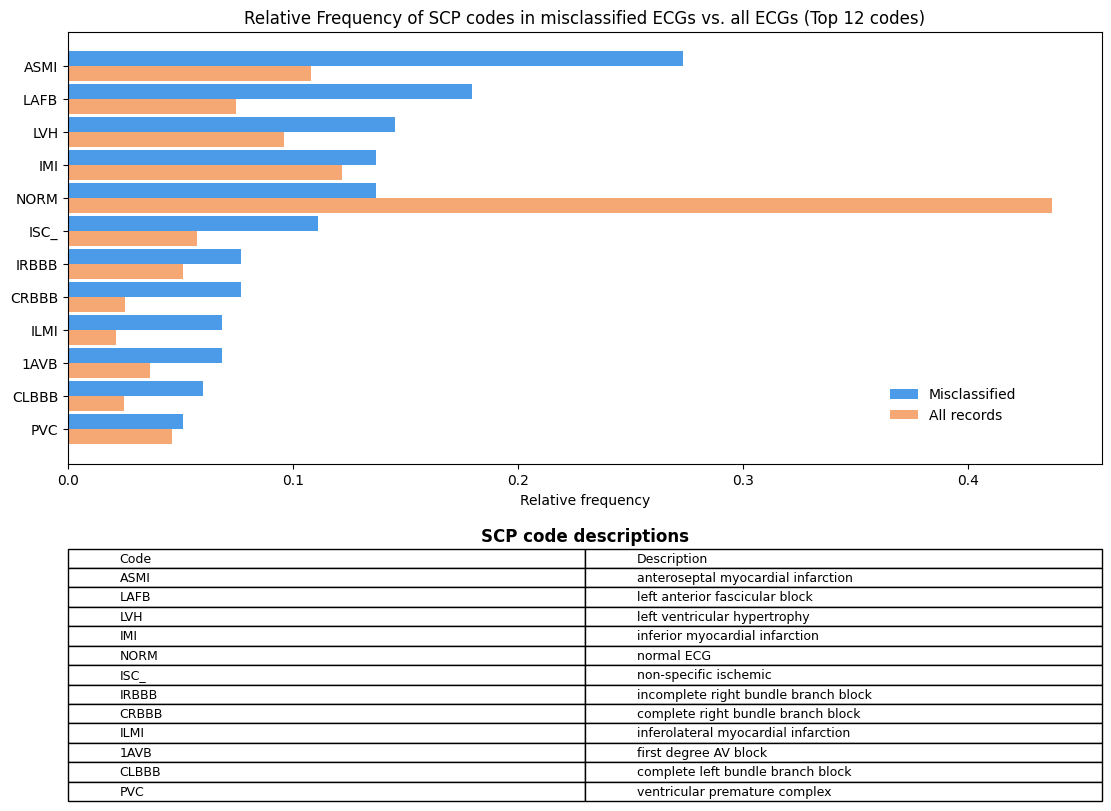

In [120]:
pretty_code_density_plot(
    code_densities,
    outlier_code_densities,
    scp_statement_csv="../../data/raw/ptb-xl/scp_statements.csv",
)

In [121]:
# Lets take a look at how pacemakers affect the ECG signal

# Filter samples that contain pacemakers
pacemaker_idx = np.where(meta["scp_codes"].apply(lambda x: "PACE" in x.keys()))[0]
print(len(pacemaker_idx))

29


In [122]:
# Calculate accuracy on pacemaker samples
pacemaker_acc = set_level_accuracy(predictions=hungarian_preds[pacemaker_idx])
pacemaker_acc

np.float64(0.3793103448275862)

<Axes: title={'center': 'ECG signals array | sr=100 Hz'}, xlabel='Samples', ylabel='Leads'>

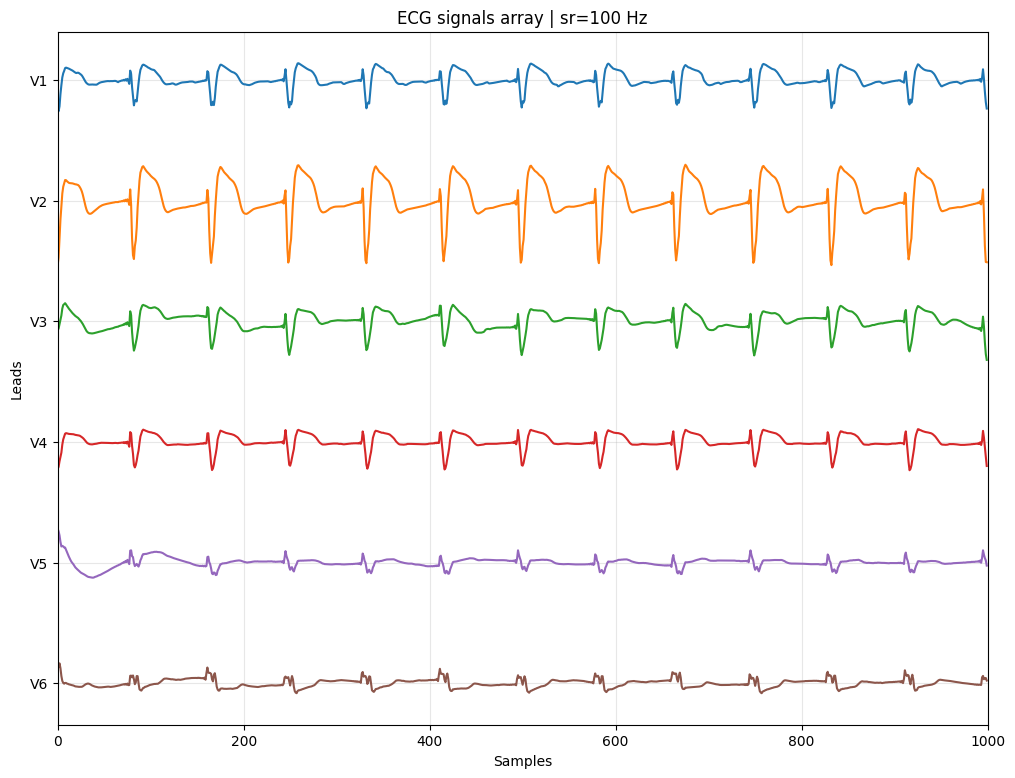

In [123]:
# Lets take a peek at what the signals look like for the pacemaker samples
signals = val_data_filtered[pacemaker_idx].cpu().numpy()
plot_ecg(signals[5], sampling_rate=100)

In [124]:
# I want to inspect why the model is misclassifying "NORM" ECGs

# Filter samples that contain NORM
norm_idx = np.where(meta["scp_codes"].apply(lambda x: "NORM" in x.keys()))[0]

# Filter misclassified samples that contain NORM
# These are just indices that are both in the wrong_hungarian and norm_idx arrays
wrong_norm_idx = np.intersect1d(wrong_hungarian, norm_idx)
print("Number of misclassified NORM samples: " + str(len(wrong_norm_idx)))

Number of misclassified NORM samples: 16


{'NORM': 80.0, 'STACH': 0.0}
sinustachykardie lagetyp normal sonst normales ekg
electrodes problems: nan
extra_beats: nan
model predicted: [0 1 2 4 3 5]
raw logits: tensor([[  9.9798,   2.4062,   1.7968,  -9.9479, -10.8789,  -9.4585],
        [ -1.1982,   6.4884,   1.5706,  -2.2487,  -7.5895, -11.6941],
        [ -1.7286,   2.0945,   6.9292,  -2.1883,  -9.4288, -13.2537],
        [ -7.0681,  -4.7748,  -6.2004,   1.5864,   6.5257,   1.0374],
        [ -8.2052,  -5.5565,  -6.6811,   5.4577,   1.5875,  -1.0539],
        [ -7.8966,  -4.9592,  -6.5899,   0.2895,   1.6373,   7.4304]])


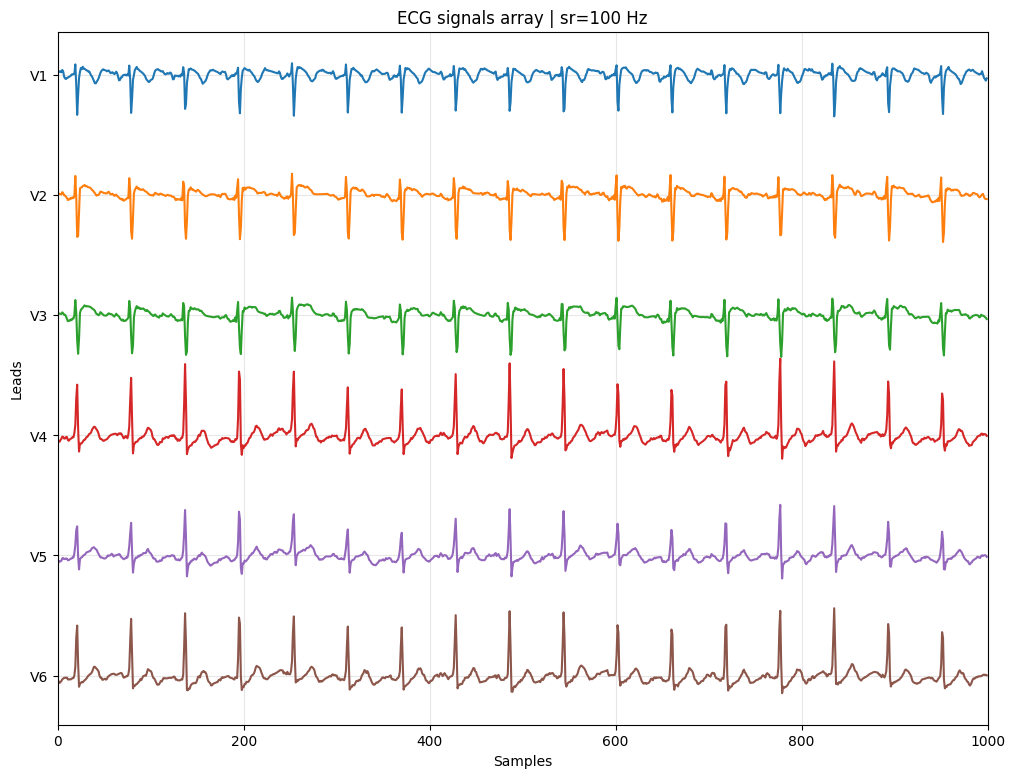

In [125]:
idx = wrong_norm_idx[2]
signals = val_data_filtered[idx].cpu().numpy()
plot_ecg(signals, sampling_rate=100)
print(meta.iloc[idx].scp_codes)
print(meta.iloc[idx].report)
print("electrodes problems: " + str(meta.iloc[idx].electrodes_problems))
print("extra_beats: " + str(meta.iloc[idx].extra_beats))
print("model predicted: " + str(hungarian_preds[idx]))
print("raw logits: " + str(logits[idx]))

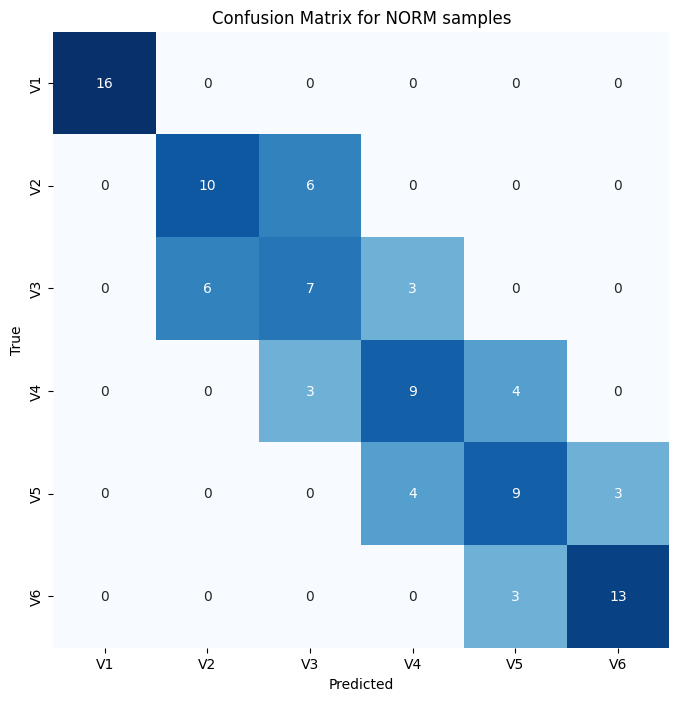

In [199]:
# I want to check which types of errors are made the most.
# I can do this by checking the difference between the predicted and target labels
# and counting the number of times each type of error is made.

cm = confusion_matrix(hungarian_preds[wrong_norm_idx], targets.cpu().numpy()[wrong_norm_idx])
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Confusion Matrix for NORM samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    

{'NORM': 50.0, 'VCLVH': 0.0, 'SR': 0.0}
sinus rhythm. voltages are high in chest leads suggesting lvh. otherwise normal ecg.
electrodes problems: nan
extra_beats: nan
predicted: [0 2 1 3 4 5]


<Axes: title={'center': 'ECG signals array | sr=100 Hz'}, xlabel='Samples', ylabel='Leads'>

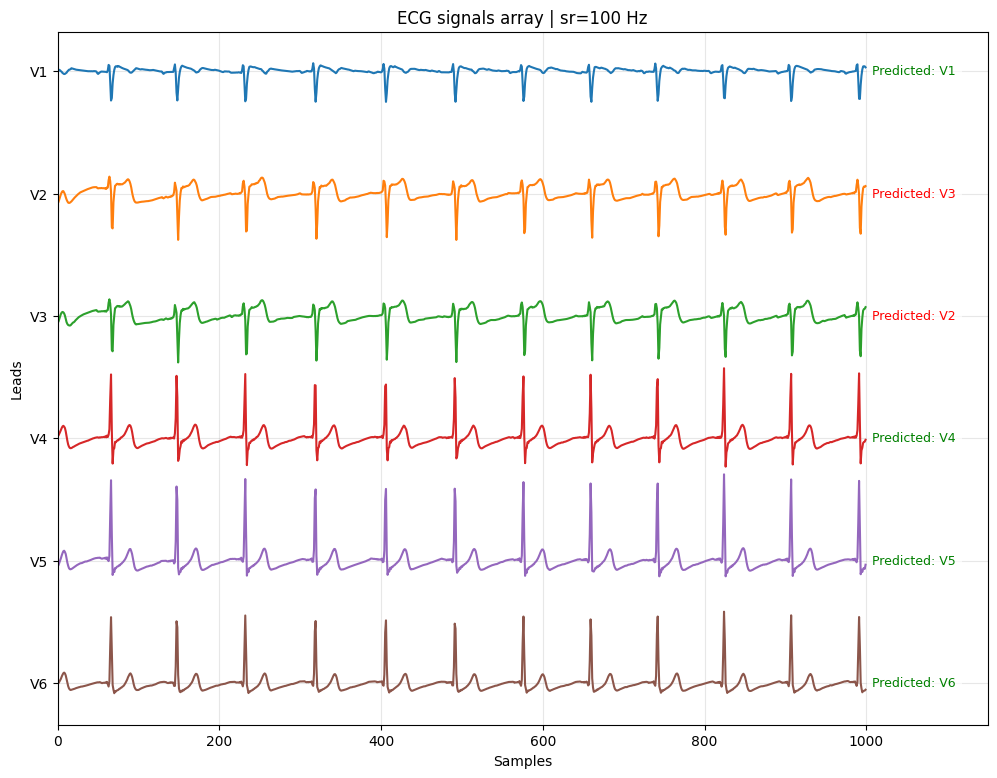

In [210]:
# Find the case where the model predicted V2 but the target was V4
idx = np.where((hungarian_preds[wrong_norm_idx] == 1) & (targets.cpu().numpy()[wrong_norm_idx] == 2))[0]
idx = wrong_norm_idx[idx[2]]
signals = val_data_filtered[idx].cpu().numpy()
print(meta.iloc[idx].scp_codes)
print(meta.iloc[idx].report)
print("electrodes problems: " + str(meta.iloc[idx].electrodes_problems))
print("extra_beats: " + str(meta.iloc[idx].extra_beats))
print("predicted: " + str(hungarian_preds[idx]))
PRECORDIAL_LEAD_NAMES = np.asarray(PRECORDIAL_LEAD_NAMES)
str_predictions = PRECORDIAL_LEAD_NAMES[hungarian_preds[idx]]
plot_ecg(signals, sampling_rate=100, predictions=str_predictions)

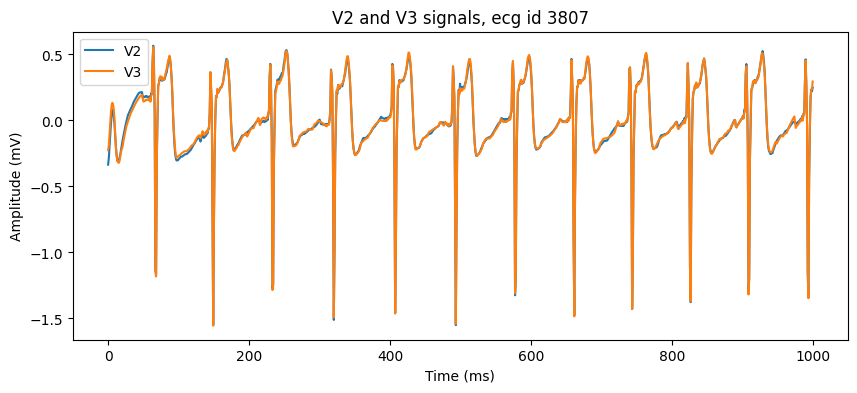

In [215]:
# Lets just plot V2 and V3
plt.figure(figsize=(10, 4))
plt.plot(signals[1], label="V2")
plt.plot(signals[2], label="V3")
plt.title(f"V2 and V3 signals, ecg id {meta.iloc[idx].ecg_id}")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()

In [208]:
idx

np.int64(167)

In [216]:
# Get the probabilities for the predictions
print(probs[idx])

[[99.23  0.56  0.21  0.    0.    0.  ]
 [ 0.87 20.58 78.54  0.01  0.    0.  ]
 [ 1.21 43.25 55.53  0.01  0.    0.  ]
 [ 0.    0.    0.   99.78  0.16  0.06]
 [ 0.    0.    0.    0.12 99.58  0.3 ]
 [ 0.    0.    0.    0.03  0.31 99.66]]


In [218]:
metadata = meta.iloc[idx]
# Print the metadata without cutting off the text
pd.set_option('display.max_colwidth', None)
print(metadata.to_string(index=True))

Unnamed: 0                                                                                                      3788
ecg_id                                                                                                          3807
patient_id                                                                                                    1717.0
age                                                                                                             41.0
sex                                                                                                                0
height                                                                                                         178.0
weight                                                                                                          80.0
nurse                                                                                                            4.0
site                                                            

Unnamed: 0                                               9
ecg_id                                                  10
patient_id                                          9456.0
age                                                   22.0
sex                                                      1
height                                                 NaN
weight                                                56.0
nurse                                                  2.0
site                                                   0.0
device                                           CS-12   E
recording_date                         1984-12-12 14:12:46
report                          sinusrhythmus normales ekg
scp_codes                       {'NORM': 100.0, 'SR': 0.0}
heart_axis                                             NaN
infarction_stadium1                                    NaN
infarction_stadium2                                    NaN
validated_by                                           N

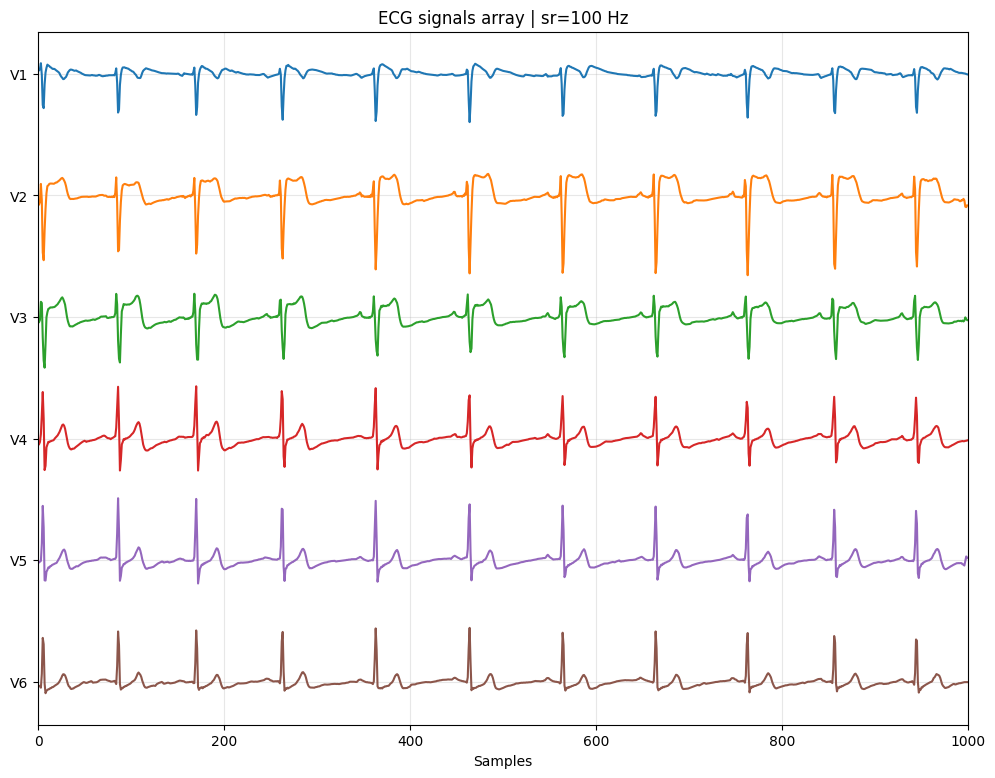

In [42]:
idx = norm_idx[0]
signals = val_data_filtered[idx].cpu().numpy()
plot_ecg(signals, sampling_rate=100)
print(meta.iloc[idx])
print(hungarian_preds[idx])

[0.98350893 0.94457169 0.94594595 0.94090701 0.95464956 0.96747595]


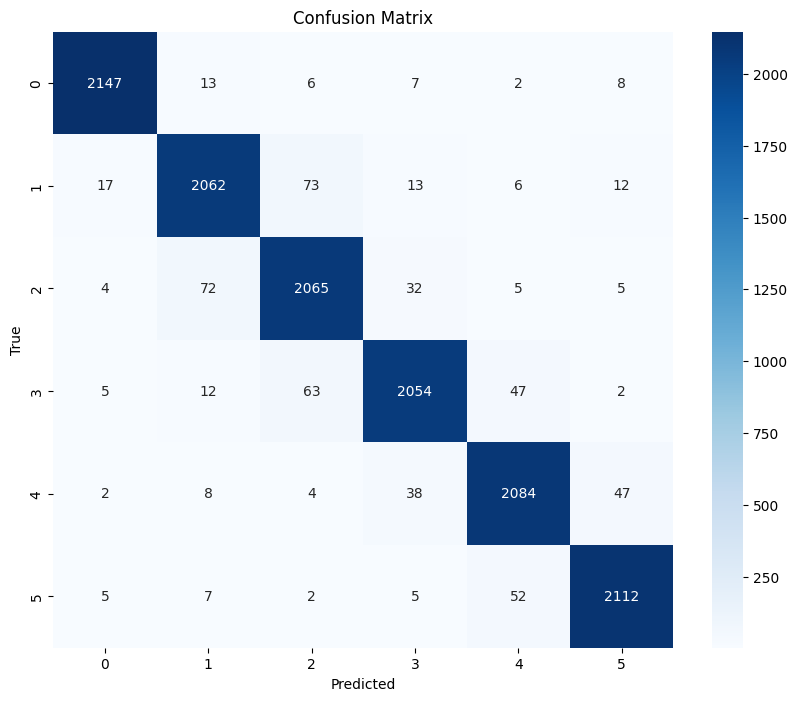

In [44]:
# Lets compute the per electrode accuracy
# preds is of shape (2183, 6)
# targets is of shape (2183, 6)
# We want to compute the accuracy for each lead separately
lead_acc = np.zeros((6,))
for i in range(6):
    lead_acc[i] = np.mean(preds[:, i] == targets[:, i].cpu().numpy())
print(lead_acc)

def confusion_matrix(preds, targets, num_classes=6):
    # preds is of shape (2183, 6)
    # targets is of shape (2183, 6)

    cm = np.zeros((num_classes, num_classes))
    for i in range(len(preds)):
        cm[targets[i], preds[i]] += 1

    cm = np.nan_to_num(cm)
    return cm

cm = confusion_matrix(preds, targets.cpu().numpy())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [45]:
print(preds.shape)
print(preds.shape)

(2183, 6)
(2183, 6)


In [46]:
# Find outliers

# These are samples where the model predicted all 6 classes wrong 
outliers = np.where(np.all(preds != targets.cpu().numpy(), axis=1))[0]
print(outliers)
print(preds[outliers])
print(len(outliers))

# print("Probabilities:")
# print(probs[outliers])

# These are samples where the model predicted all 6 classes right
correct = np.where(np.all(preds == targets.cpu().numpy(), axis=1))[0]

[1215 1753 1911 2100]
[[5 4 3 1 1 1]
 [3 2 4 4 5 0]
 [5 2 1 1 3 4]
 [2 2 0 4 5 4]]
4


Signal 1215


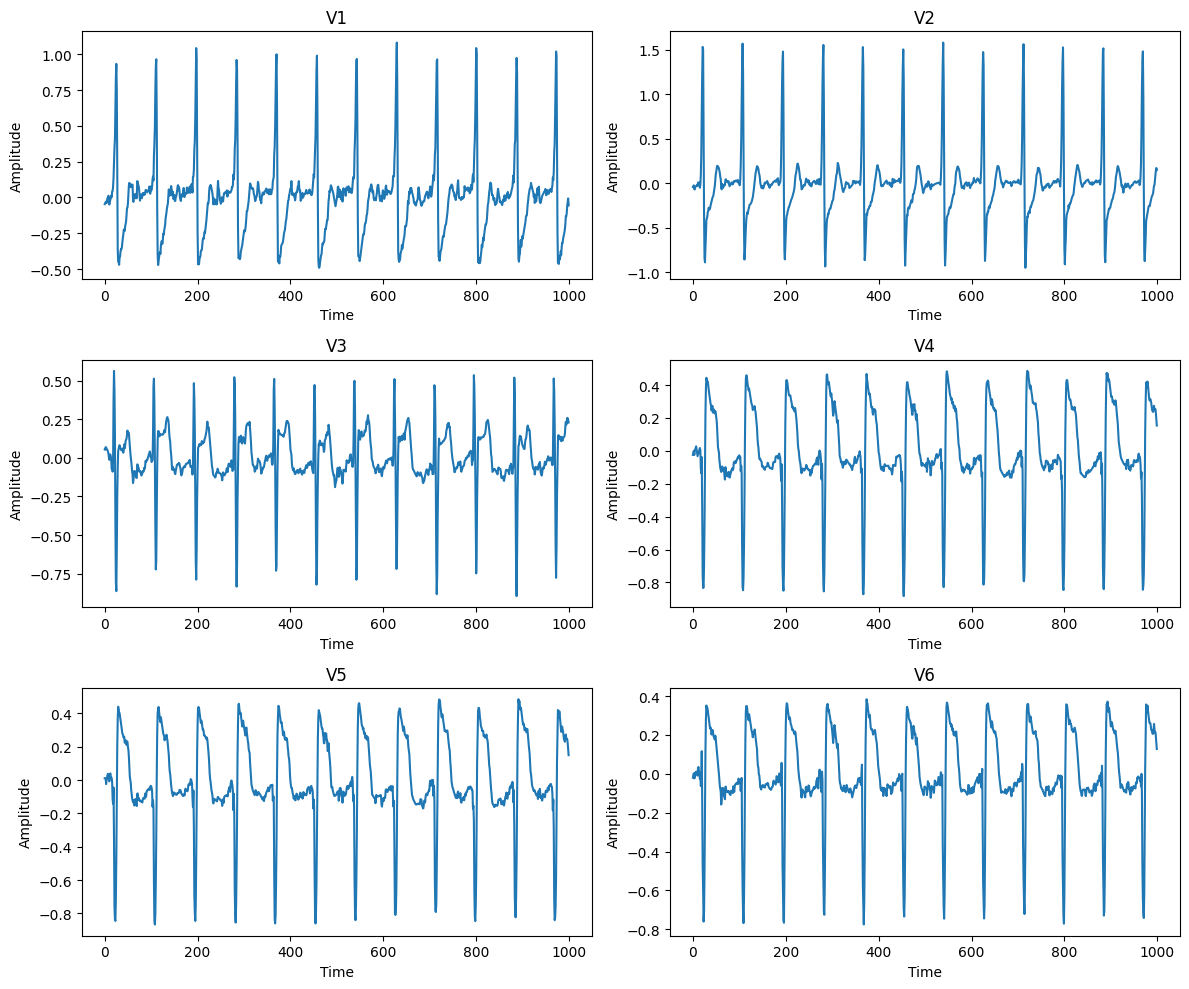

Predictions:
[5 4 3 1 1 1]
Prediction Probabilities:
[[ 0.04  0.    0.    0.13  0.51 99.32]
 [ 0.06  0.02  0.04  0.08 98.89  0.91]
 [ 0.01  0.01  0.04 99.67  0.25  0.01]
 [ 5.37 60.94 33.55  0.14  0.    0.  ]
 [ 3.99 51.7  44.17  0.14  0.    0.  ]
 [39.8  40.12 19.81  0.27  0.    0.  ]]


In [47]:
# lets take a look at the signals from one of the outliers

idx = outliers[0]
print(f"Signal {idx}")
signals = val_data_filtered[idx]
plot_signals(signals, time_cutoff=1000)
print("Predictions:")
print(preds[idx])
print("Prediction Probabilities:")
print(probs[idx])

In [48]:
# I want to find all cases where the model predicted a lead more than 2 "positions" away from the correct lead
# E.g. if the model predicted 0, but the correct lead was 3, this is a distance of 3
wrongness_thresh = 4
wrong = np.where(np.abs(preds - targets.cpu().numpy()) > wrongness_thresh)[0]
print(len(wrong))
print(preds[wrong])

13
[[0 3 3 2 5 0]
 [5 1 2 2 1 4]
 [5 4 2 2 1 0]
 [5 4 2 2 1 0]
 [5 1 1 3 5 5]
 [5 2 2 2 5 0]
 [5 2 2 2 5 0]
 [5 4 3 1 1 1]
 [5 0 2 4 1 0]
 [5 0 2 4 1 0]
 [3 2 4 4 5 0]
 [5 2 1 1 3 4]
 [5 0 2 2 3 5]]


Signal 304


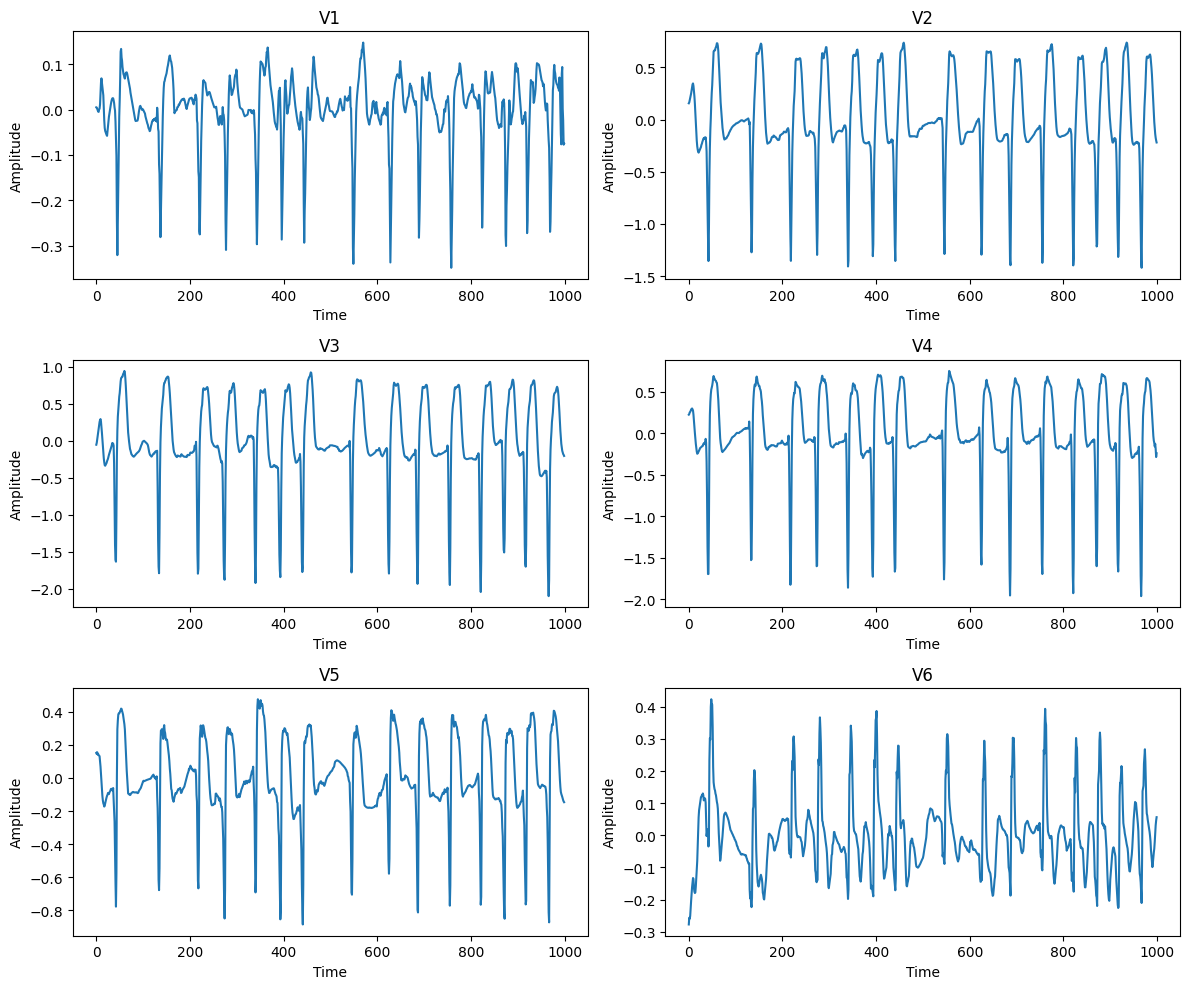

Predictions:
[5 1 2 2 1 4]
Prediction Probabilities:
[[ 0.2   0.44  0.02  0.01  0.73 98.6 ]
 [ 2.61 70.9  12.24 13.77  0.45  0.03]
 [ 3.69 23.95 43.03 25.84  3.29  0.19]
 [ 0.8  42.72 47.61  8.47  0.36  0.04]
 [ 2.36 38.46 24.6  33.17  1.32  0.08]
 [ 6.81  0.22  0.01  0.03 92.75  0.18]]


In [49]:
# Lets inspect these very wrong predictions
idx = wrong[1]
print(f"Signal {idx}")
signals = val_data_filtered[idx]
plot_signals(signals, time_cutoff=1000)
print("Predictions:")
print(preds[idx])
print("Prediction Probabilities:")
print(probs[idx])

I am now going to see how the model performs when being validated on a set of only "normal" heartbeats.

In [18]:
val_data_norm = np.load('../../data/processed/ptbxl100norm/val.npy')
print(val_data_norm.shape)

(955, 1000, 6)


In [19]:
# Preprocess the data
val_data_norm = apply_preprocessors(val_data_norm, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)

In [20]:
# Convert to tensor
val_data_norm = torch.from_numpy(val_data_norm).float()
val_data_norm = val_data_norm.permute(0, 2, 1)
print(val_data_norm.shape)

torch.Size([955, 6, 1000])


In [21]:
# Create a dataloader for the validation data
dataset_norm = SigLocDataset(val_data_norm)
batch_size = 64
dataloader_norm = DataLoader(dataset_norm, batch_size=batch_size, shuffle=False)

In [26]:
model.eval()
logits = np.zeros((len(dataset_norm), 6, 6))
cursor = 0

for batch in dataloader_norm:
    batch = batch.to('cuda')

    with torch.no_grad():
        _, these_logits = model(batch)
        b = these_logits.shape[0]

        logits[cursor:cursor + b] = these_logits.cpu().numpy()
        cursor += b  # advance the write pointer

assert cursor == len(dataset_norm), f"Expected {len(dataset_norm)} samples, got {cursor}"
logits.shape

(955, 6, 6)

In [27]:
targets = torch.arange(6, device=logits[0].device).expand(logits.shape[0], -1)

# Convert logits to tensor
logits = torch.from_numpy(logits).float()

# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs[0])

# Lead-wise accuracy
preds = logits.argmax(dim=2).cpu().numpy()

lead_acc = lead_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
set_acc = set_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

[[99.83  0.08  0.09  0.    0.    0.  ]
 [ 0.09 99.79  0.12  0.    0.    0.  ]
 [ 0.01  0.04 99.95  0.    0.    0.  ]
 [ 0.    0.    0.   99.87  0.1   0.02]
 [ 0.    0.    0.    0.17 99.61  0.21]
 [ 0.    0.    0.    0.02  0.19 99.79]]
Set level accuracy: 0.9654
Lead level accuracy: 0.9911


In [28]:
hungarian_preds = hungarian_predictions(logits)
hungarian_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
hungarian_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
print(f"Hungarian Set level accuracy: {hungarian_set_acc:.4f}")
print(f"Hungarian Lead level accuracy: {hungarian_lead_acc:.4f}")

Hungarian Set level accuracy: 0.9791
Hungarian Lead level accuracy: 0.9923


In [84]:
# These are samples where the model predicted all 6 classes wrong 
outliers = np.where(np.all(preds != targets.cpu().numpy(), axis=1))[0]
print(outliers)
print(preds[outliers])
print(len(outliers))

[]
[]
0


[0.99895288 0.99267016 0.99162304 0.98324607 0.98848168 0.99162304]


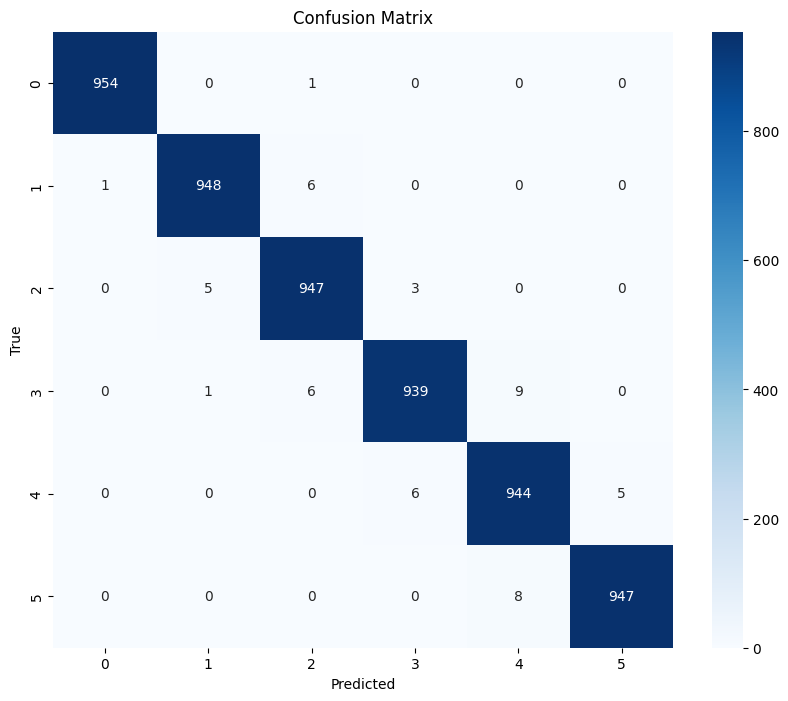

In [85]:
# Lets compute the per electrode accuracy
# preds is of shape (2183, 6)
# targets is of shape (2183, 6)
# We want to compute the accuracy for each lead separately
lead_acc = np.zeros((6,))
for i in range(6):
    lead_acc[i] = np.mean(preds[:, i] == targets[:, i].cpu().numpy())
print(lead_acc)

def confusion_matrix(preds, targets, num_classes=6):
    # preds is of shape (2183, 6)
    # targets is of shape (2183, 6)

    cm = np.zeros((num_classes, num_classes))
    for i in range(len(preds)):
        cm[targets[i], preds[i]] += 1

    cm = np.nan_to_num(cm)
    return cm

cm = confusion_matrix(preds, targets.cpu().numpy())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Now lets load the new model, SigLab, which uses the Hungarian algorithm to assign leads to signals.

In [4]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact("nateml-maastricht-university/bachelors-thesis/05_siglab_baseline_best:best")
artifact_path = artifact.download()

run = api.run("nateml-maastricht-university/bachelors-thesis/yzyhglwb")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


In [5]:
from bachelors_thesis.modeling.siglab import SigLab

# Load the model
checkpoint = torch.load(artifact_path + "/05_siglab_baseline_best.pth", map_location=torch.device('cuda'))

# Cast the model to the correct type
model = SigLab(cfg.model)
model.to("cuda")
model.load_state_dict(checkpoint)
model.eval()

SigLab(
  (local_encoder): LocalEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 16, kernel_size=(12,), stride=(1,), padding=(3,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(1,))
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): ReLU()
      (8): AdaptiveAvgPool1d(output_size=1)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=128, out_features=64, bias=True)
      (11): ReLU()
    )
  )
  (context_encoder): DeepSetsContextEncoder(
    (phi): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
    )
    (rho): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=T

In [6]:
val_data = np.load('../../data/processed/ptbxl100all/val.npy')
val_data = apply_preprocessors(val_data, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)
val_data = torch.from_numpy(val_data).float()
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

torch.Size([2183, 6, 1000])


In [7]:
# Create a dataloader for the validation data
dataset = SigLocDataset(val_data)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [11]:
from bachelors_thesis.modeling.siglab import permutation_loss

model.eval()
predictions = np.zeros((len(dataset), 6))
total_loss = 0
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to('cuda')

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        # these_logits = model(batch)
        logits = model.forward(batch)
        print(logits)
        #these_predictions = model.predict_leads(batch)
        these_predictions = model.predict(logits)
        predictions[(idx * batch_size):(idx * batch_size + batch_size)] = these_predictions
        # logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

print(predictions.shape)

torch.Size([64, 6, 1000])
tensor([[[   3.4197,  -11.7860,  -23.1987,    3.7429,   -6.7507,  -36.4208],
         [   1.1232,   39.5327,  -71.6256,  -33.7116,  -46.0432,  -79.8393],
         [   6.0989,   -9.5091,  -28.1608,    2.4368,  -10.2143,  -42.0943],
         [ -17.4525,  -34.9408,    0.9053,    0.1157,    9.5977,  -16.2106],
         [ -32.2600,  -51.4994,   10.4716,  -12.1204,    1.5324,   -6.3291],
         [ -50.8779,  -78.6943,    6.1080,  -27.3554,  -11.4436,   19.6012]],

        [[   8.4531,   -5.9075,  -31.1823,    5.5957,  -10.8010,  -46.5122],
         [   5.8961,   -9.3236,  -29.0922,    7.5589,   -8.9198,  -45.1641],
         [  -4.9816,   47.0397,  -74.9199,  -36.0029,  -49.5215,  -84.6645],
         [ -26.9304,  -52.8893,    3.3208,   -1.3328,   18.2649,  -20.2611],
         [ -44.1966,  -71.9590,   16.0005,  -20.6617,   -1.5856,   -4.1268],
         [ -53.5348,  -79.9577,    0.3681,  -31.2053,  -16.7425,   30.8063]],

        [[  -7.8255,   60.0700,  -87.0479,  -4

In [10]:
predictions[0]

array([3., 1., 0., 4., 2., 5.])

In [ ]:
from bachelors_thesis.modeling.siglab import permutation_loss

loss = permutation_loss

In [9]:
predictions

array([[3., 1., 0., 4., 2., 5.],
       [0., 3., 1., 4., 2., 5.],
       [1., 3., 0., 4., 2., 5.],
       ...,
       [1., 0., 3., 4., 2., 5.],
       [1., 0., 3., 4., 2., 5.],
       [1., 0., 3., 4., 2., 5.]])

In [98]:
targets = torch.arange(6, device=logits[0].device).expand(2183, -1)

# Convert logits to tensor
logits = torch.from_numpy(logits).float()

# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs[0])

preds = np.argmax(logits.cpu().numpy(), axis=2)

# Accuracy
lead_acc = lead_level_accuracy(logits.cpu().numpy(), targets.cpu().numpy())
set_acc = set_level_accuracy(logits.cpu().numpy(), targets.cpu().numpy())
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

[[ 41.99   0.     0.    58.01   0.     0.  ]
 [  0.   100.     0.     0.     0.     0.  ]
 [ 97.5    0.     0.     2.5    0.     0.  ]
 [  0.     0.     0.02   0.01  99.98   0.  ]
 [  0.     0.    99.99   0.     0.01   0.  ]
 [  0.     0.     0.     0.     0.   100.  ]]
Set level accuracy: 0.0000
Lead level accuracy: 0.2648


## Inception Style SigLoc

In [1]:
project_path = "nateml-maastricht-university/bachelors-thesis"
run_id = "j8bdg20p"
artifact_name = "15_sigloc-nolan_resnet_best"

In [6]:
from bachelors_thesis.modeling.sigloc import SigLocNolan
import ast

# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact(f"{project_path}/{artifact_name}:best")
artifact_path = artifact.download()

run = api.run(f"{project_path}/{run_id}")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)
cfg.model.context_encoder.enabled = True

# Load the model
checkpoint = torch.load(artifact_path + f"/{artifact_name}.pth", map_location=torch.device('cuda'))

# Cast the model to the correct type
model = SigLocNolan(cfg.model)
model.to("cuda")
model.load_state_dict(checkpoint)
model.eval()

# Load the validation data
val_data = np.load('../../data/processed/ptbxl100all/val.npy')
meta = pd.read_csv('../../data/processed/ptbxl100all/meta_val.csv')

# Convert scp code strings to dictionaries
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(codes_above_threshold)

print(val_data.shape)
print(meta.shape)

val_data_filtered = apply_preprocessors(val_data, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)

# Convert to tensor
val_data_filtered = torch.from_numpy(val_data_filtered).float()
val_data_filtered = val_data_filtered.permute(0, 2, 1)
print(val_data_filtered.shape)

# Create a dataloader for the validation data
dataset = SigLocDataset(val_data_filtered)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

wandb:   1 of 1 files downloaded.  


(2183, 1000, 6)
(2183, 31)
torch.Size([2183, 6, 1000])


In [7]:
model.eval()
logits = np.zeros((len(dataset), 6, 6))
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to('cuda')

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        _, these_logits = model(batch)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

logits.shape

torch.Size([64, 6, 1000])


(2183, 6, 6)

In [8]:
# Calculate model accuracy
targets = torch.arange(6, device=logits[0].device).expand(2183, -1)

# Convert logits to tensor
if isinstance(logits, np.ndarray):
    logits = torch.from_numpy(logits).float()

# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# accuracy
set_acc = set_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
lead_acc = lead_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

Set level accuracy: 0.8731
Lead level accuracy: 0.9595


In [55]:
# Calculate hungarian accuracy
preds = np.argmax(logits.cpu().numpy(), axis=2)
hungarian_preds = hungarian_predictions(logits)
hungarian_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
hungarian_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
print(f"Hungarian Set level accuracy: {hungarian_set_acc:.4f}")
print(f"Hungarian Lead level accuracy: {hungarian_lead_acc:.4f}")

Hungarian Set level accuracy: 0.9217
Hungarian Lead level accuracy: 0.9653


In [12]:
# Find outliers
mistake_mask = hungarian_preds != targets.cpu().numpy()
mistake_counts = mistake_mask.sum(axis=1)
wrongness_thresh = 6
wrong_hungarian = np.where(mistake_counts >= wrongness_thresh)[0]
len(wrong_hungarian)

5

In [13]:
print(wrong_hungarian)

[ 483 1146 1215 1753 1911]


atrial fibrillation. premature ventricular contraction(s). non-specific intraventricular block. qs complexes in v2,3,4 consistent with old    anterior myocardial infarction. q waves in i, avl, v6 consistent with old lateral   myocardial infarction.


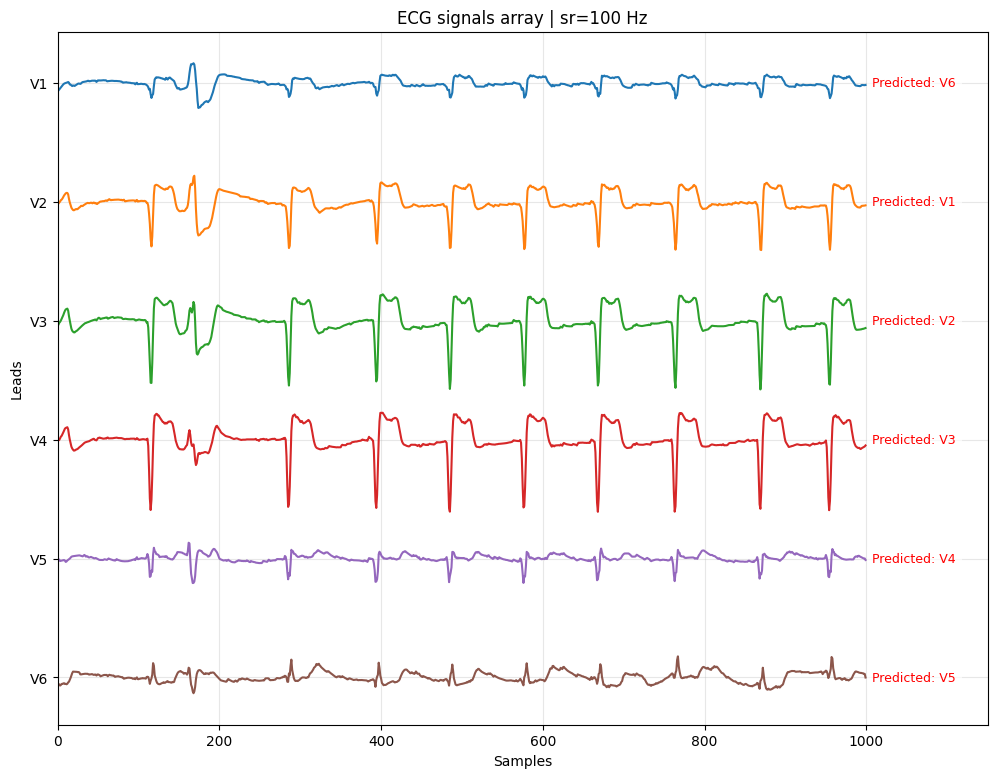

In [18]:
idx = wrong_hungarian[4]
signals = val_data_filtered[idx].cpu().numpy()
str_predictions = [PRECORDIAL_LEAD_NAMES[p] for p in hungarian_preds[idx]]
plot_ecg(signals, sampling_rate=100, predictions=str_predictions)
print(meta.iloc[idx].report)

In [19]:
# Calculate accuracy on pacemaker samples
pacemaker_idx = np.where(meta["present_codes"].apply(lambda x: "PACE" in x))[0]
print(len(pacemaker_idx))

pacemaker_acc = set_level_accuracy(predictions=hungarian_preds[pacemaker_idx])
pacemaker_acc

27


np.float64(0.48148148148148145)

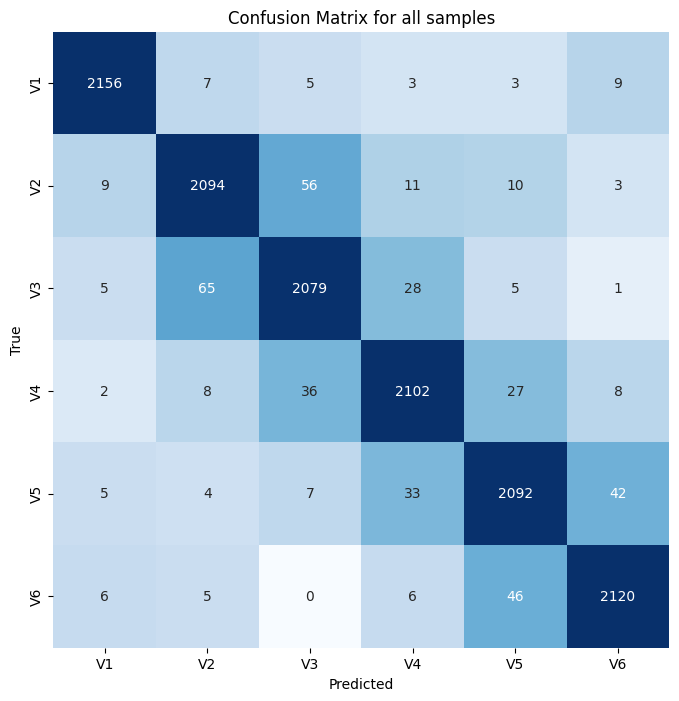

In [21]:
# Confusion matrix

cm = confusion_matrix(hungarian_preds, targets.cpu().numpy())
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Confusion Matrix for all samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    

In [23]:
meta.present_codes

0        {IMI}
1       {NORM}
2       {AFLT}
3       {AFLT}
4       {AFLT}
         ...  
2178    {NORM}
2179     {IMI}
2180    {PACE}
2181    {NORM}
2182    {NORM}
Name: present_codes, Length: 2183, dtype: object

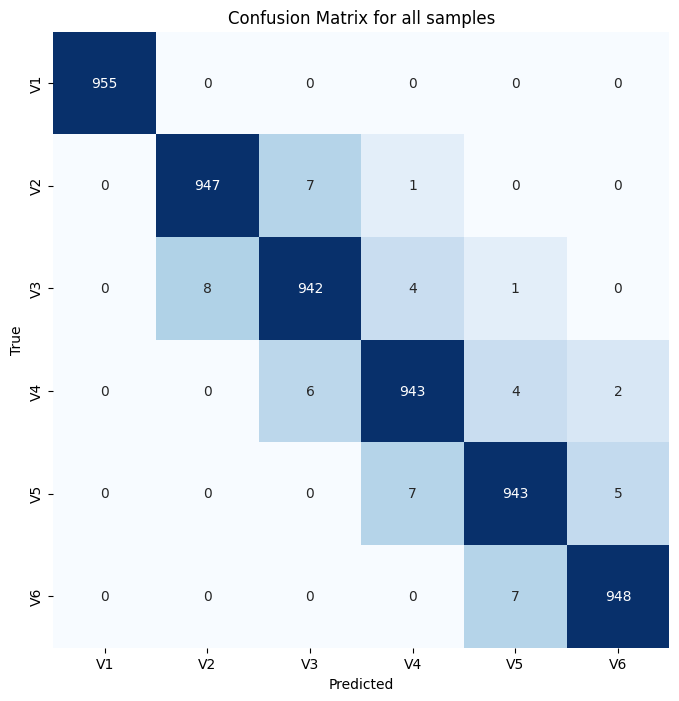

In [39]:
# Confusion matrix for NORM samples
norm_idx = np.where(meta["present_codes"].apply(lambda x: "NORM" in x))[0]

cm = confusion_matrix(hungarian_preds[norm_idx], targets.cpu().numpy()[norm_idx])
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Confusion Matrix for all samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    

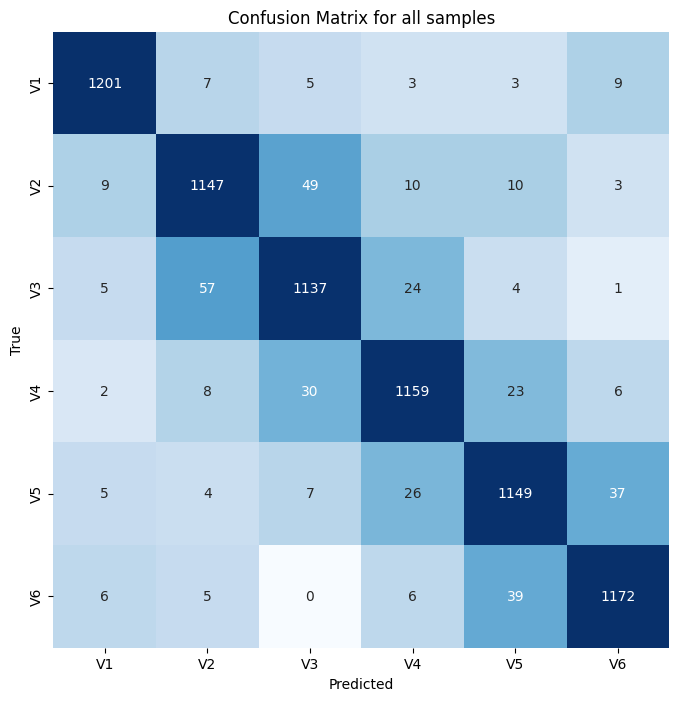

In [40]:
not_norm_idx = np.where(meta["present_codes"].apply(lambda x: "NORM" not in x))[0]

cm = confusion_matrix(hungarian_preds[not_norm_idx], targets.cpu().numpy()[not_norm_idx])
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Confusion Matrix for all samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    

In [43]:
norm_in_superclass = np.where(meta["diagnostic_superclass"].apply(lambda x: "NORM" in x))[0]
print(len(norm_in_superclass))

955


In [46]:
# Normal samples
norm_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "NORM" in x))[0]
print("Normal: ", len(norm_idx))

# Mycardial infarction samples
mi_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "MI" in x))[0]
print("Mycardial Infarction: ", len(mi_idx))

# ST/T change
sttc_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "STTC" in x))[0]
print("ST/T change: ", len(sttc_idx))

# Conduction disturbance
cd_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "CD" in x))[0]
print("Conduction disturbance: ", len(cd_idx))

# Hypertrophy
hypertrophy_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "HYP" in x))[0]
print("Hypertrophy: ", len(hypertrophy_idx))

Normal:  955
Mycardial Infarction:  540
ST/T change:  528
Conduction disturbance:  495
Hypertrophy:  268


In [47]:
print(len(norm_idx) + len(mi_idx) + len(sttc_idx) + len(cd_idx) + len(hypertrophy_idx))

2786


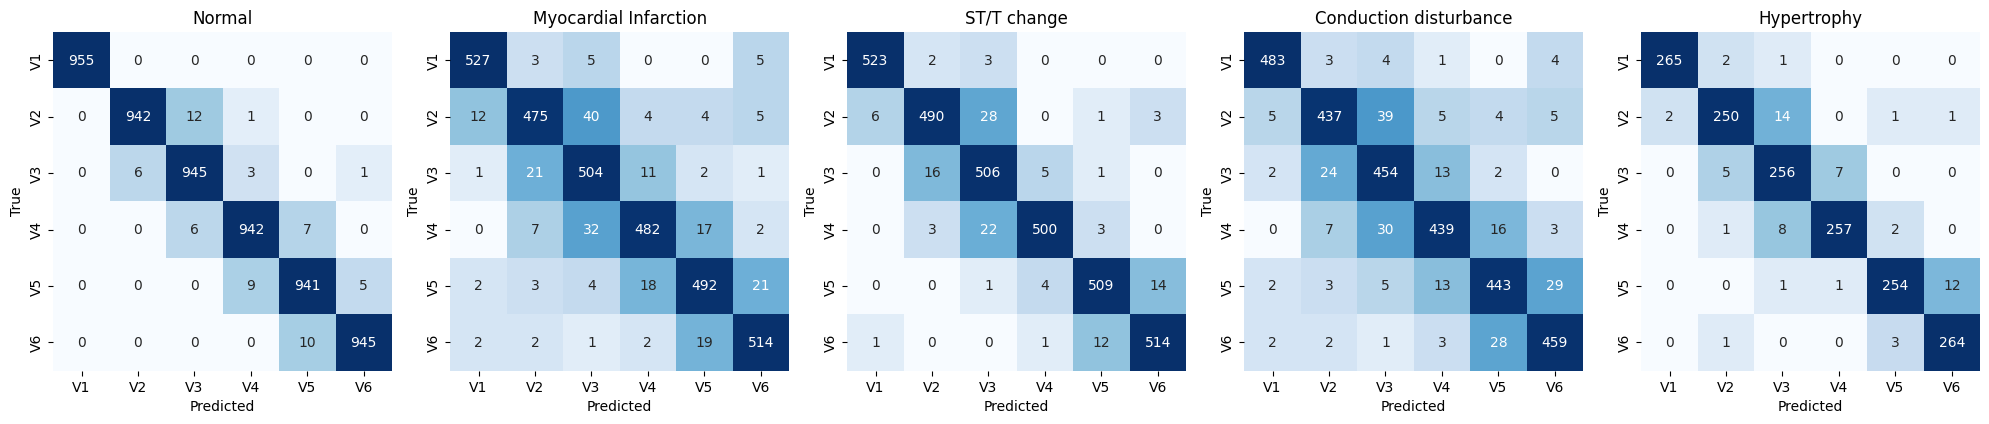

In [58]:
# Calculate confusion matrices for each subset
cm_norm = confusion_matrix(preds[norm_idx], targets.cpu().numpy()[norm_idx])
cm_mi = confusion_matrix(preds[mi_idx], targets.cpu().numpy()[mi_idx])
cm_sttc = confusion_matrix(preds[sttc_idx], targets.cpu().numpy()[sttc_idx])
cm_cd = confusion_matrix(preds[cd_idx], targets.cpu().numpy()[cd_idx])
cm_hypertrophy = confusion_matrix(preds[hypertrophy_idx], targets.cpu().numpy()[hypertrophy_idx])

# Log-transform the confusion matrices for better visualization
cm_norm_log = np.log(cm_norm + 1)
cm_mi_log = np.log(cm_mi + 1)
cm_sttc_log = np.log(cm_sttc + 1)
cm_cd_log = np.log(cm_cd + 1)
cm_hypertrophy_log = np.log(cm_hypertrophy + 1)

# Visualize the confusion matrices
plt.figure(figsize=(20, 8))
plt.subplot(1, 5, 1)
sns.heatmap(cm_norm_log, annot=cm_norm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Normal")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 2)
sns.heatmap(cm_mi_log, annot=cm_mi, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Myocardial Infarction")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 3)
sns.heatmap(cm_sttc_log, annot=cm_sttc, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("ST/T change")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 4)
sns.heatmap(cm_cd_log, annot=cm_cd, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Conduction disturbance")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 5)
sns.heatmap(cm_hypertrophy_log, annot=cm_hypertrophy, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Hypertrophy")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [57]:
# Calculate accuracies
norm_acc = set_level_accuracy(predictions=hungarian_preds[norm_idx], targets=targets.cpu().numpy()[norm_idx])
print(f"Normal Set level accuracy: {norm_acc:.4f}")
mi_acc = set_level_accuracy(predictions=hungarian_preds[mi_idx], targets=targets.cpu().numpy()[mi_idx])
print(f"Myocardial Infarction Set level accuracy: {mi_acc:.4f}")
sttc_acc = set_level_accuracy(predictions=hungarian_preds[sttc_idx], targets=targets.cpu().numpy()[sttc_idx])
print(f"ST/T change Set level accuracy: {sttc_acc:.4f}")
cd_acc = set_level_accuracy(predictions=hungarian_preds[cd_idx], targets=targets.cpu().numpy()[cd_idx])
print(f"Conduction disturbance Set level accuracy: {cd_acc:.4f}")
hypertrophy_acc = set_level_accuracy(predictions=hungarian_preds[hypertrophy_idx], targets=targets.cpu().numpy()[hypertrophy_idx])
print(f"Hypertrophy Set level accuracy: {hypertrophy_acc:.4f}")

Normal Set level accuracy: 0.9759
Myocardial Infarction Set level accuracy: 0.8519
ST/T change Set level accuracy: 0.9223
Conduction disturbance Set level accuracy: 0.8283
Hypertrophy Set level accuracy: 0.9179


In [ ]:
# Find the case where the models predicted 